In [1]:
import pandas as pd

# Load datasets
rain = pd.read_excel("Cleaned_Rainfall_Data_Java.xlsx")
padi = pd.read_excel("./Padi/Padi/Datapadi_Laporan.xlsx")

# --- Clean rainfall data ---
rain["Province"] = rain["Province"].astype(str).str.strip()
rain["Year"] = pd.to_numeric(rain["Year"], errors="coerce").astype("Int64")
rain["Avg_rain_mm"] = pd.to_numeric(rain["Avg_rain_mm"], errors="coerce")

# Aggregate yearly rainfall per province
rain_agg = rain.groupby(["Province","Year"])["Avg_rain_mm"].mean().reset_index()

# --- Clean padi data ---
padi.columns = ["Year", "Province", "Harvested_ha", "Production_padi_ton", "Production_beras_ton"]
for col in ["Harvested_ha","Production_padi_ton","Production_beras_ton"]:
    padi[col] = (padi[col].astype(str)
                          .str.replace(".", "", regex=False)
                          .astype(float))

padi["Yield_ton_per_ha"] = (padi["Production_padi_ton"] / padi["Harvested_ha"]).round(3)

# --- Merge rainfall & yield ---
data = pd.merge(rain_agg, padi[["Province","Year","Yield_ton_per_ha"]], on=["Province","Year"], how="inner")

# Drop provinces without rainfall data
data = data[data["Province"].isin(["Banten","DKI Jakarta","Jawa Tengah","Jawa Timur"])]

print(data.head())
print("\nData shape:", data.shape)


  Province  Year  Avg_rain_mm  Yield_ton_per_ha
0   Banten  2020    11.222759             3.498
1   Banten  2021    12.376201             4.076
2   Banten  2022     7.576880             4.112
3   Banten  2023     6.102341             4.129
4   Banten  2024     8.659796             4.154

Data shape: (20, 4)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = data[["Avg_rain_mm"]]
y = data["Yield_ton_per_ha"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale features (important for SVR)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

models = {
    "Linear Regression": LinearRegression(),
    "Support Vector Regression": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
}

results = []

for name, model in models.items():
    if name == "Support Vector Regression":
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
    
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    
    results.append({"Model": name, "R2": r2, "RMSE": rmse, "MAE": mae})

results_df = pd.DataFrame(results)
print(results_df.sort_values(by="R2", ascending=False).round(3))


                       Model     R2   RMSE    MAE
1  Support Vector Regression -0.878  1.151  0.892
0          Linear Regression -1.100  1.217  0.988
2              Random Forest -1.155  1.233  1.118
3          Gradient Boosting -2.220  1.507  1.434


C:\Users\maula\AppData\Local\Temp\ipykernel_41028\2927218140.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="R2", palette="crest")


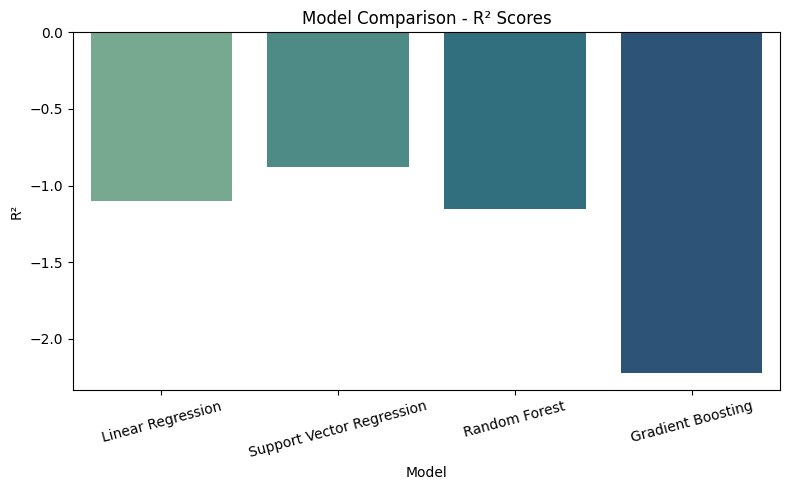

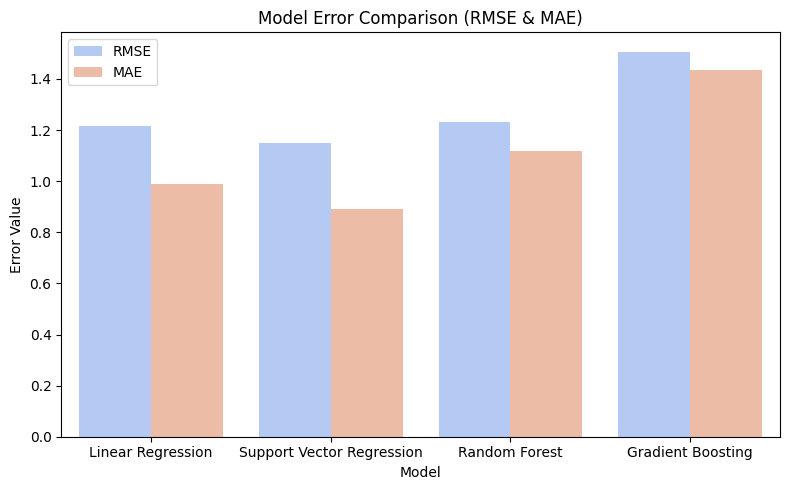

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x="Model", y="R2", palette="crest")
plt.title("Model Comparison - R² Scores")
plt.ylabel("R²")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(data=results_df.melt(id_vars="Model", value_vars=["RMSE","MAE"]),
            x="Model", y="value", hue="variable", palette="coolwarm")
plt.title("Model Error Comparison (RMSE & MAE)")
plt.ylabel("Error Value")
plt.legend(title="")
plt.tight_layout()
plt.show()
